In [2]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

# Train

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


<Axes: xlabel='Rating', ylabel='count'>

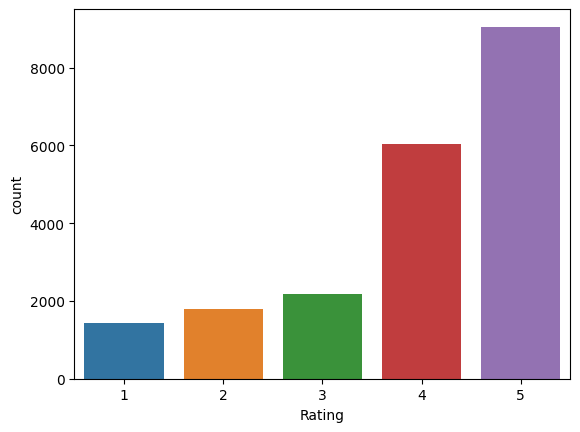

In [6]:
sns.countplot(data=df, x='Rating')

In [8]:
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'
    
df['Rating'] = df['Rating'].apply(rating)

In [9]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Bad
2,nice rooms not 4* experience hotel monaco seat...,Netral
3,"unique, great stay, wonderful time hotel monac...",Good
4,"great stay great stay, went seahawk game aweso...",Good


In [12]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

#df['Review'] = df['Review'].apply(cleaning)
#df.to_csv('cleaned.csv', index=False)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

In [17]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 64819


In [18]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

In [19]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                                                          bias_regularizer=l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           518552    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               3200      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                        

In [20]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
513/513 [==============================] - 90s 156ms/step - loss: 0.9860 - accuracy: 0.6933 - val_loss: 0.8204 - val_accuracy: 0.7360
Epoch 2/25
513/513 [==============================] - 79s 155ms/step - loss: 0.8499 - accuracy: 0.7278 - val_loss: 0.6908 - val_accuracy: 0.7360
Epoch 3/25
513/513 [==============================] - 80s 156ms/step - loss: 0.7384 - accuracy: 0.7347 - val_loss: 0.6307 - val_accuracy: 0.7360
Epoch 4/25
513/513 [==============================] - 83s 161ms/step - loss: 0.6603 - accuracy: 0.7498 - val_loss: 0.5465 - val_accuracy: 0.7785
Epoch 5/25
513/513 [==============================] - 87s 169ms/step - loss: 0.6029 - accuracy: 0.7948 - val_loss: 0.5173 - val_accuracy: 0.8131
Epoch 6/25
513/513 [==============================] - 83s 162ms/step - loss: 0.5578 - accuracy: 0.8197 - val_loss: 0.4856 - val_accuracy: 0.8290
Epoch 7/25
513/513 [==============================] - 78s 152ms/step - loss: 0.5610 - accuracy: 0.8206 - val_loss: 0.5324 - val_ac

<Axes: >

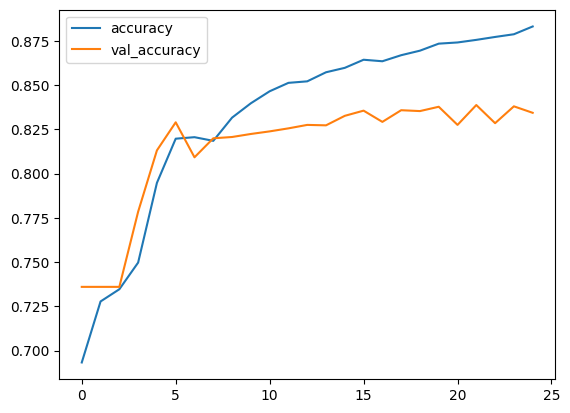

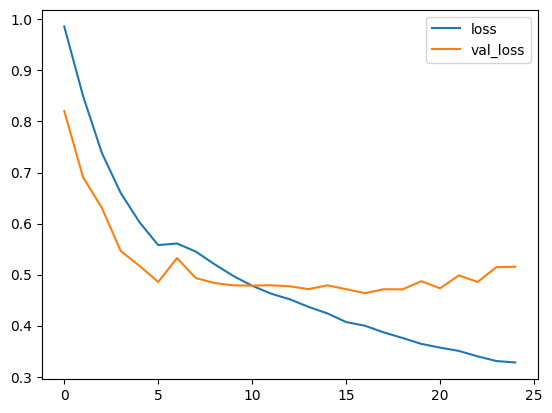

In [21]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [22]:
pred2 = model.predict(test_padded)

129/129 [==============================] - 12s 72ms/step


In [23]:
true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred2, axis=-1)

In [24]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[ 521   97   18]
 [ 114 2890   13]
 [ 176  261    9]]
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       636
           1       0.89      0.96      0.92      3017
           2       0.23      0.02      0.04       446

    accuracy                           0.83      4099
   macro avg       0.59      0.60      0.56      4099
weighted avg       0.78      0.83      0.79      4099



In [25]:
model.save('model.h5')

# Predict

In [15]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('model.h5')


In [16]:
import pickle

tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
label_binarizer = pickle.load(open('label.pkl', 'rb'))


In [20]:
new_review = "This hotel was ass"


In [21]:
cleaned_review = cleaning(new_review)  # Apply your cleaning function
review_seq = tokenizer.texts_to_sequences([cleaned_review])
review_padded = pad_sequences(review_seq)


In [22]:
predictions = loaded_model.predict(review_padded)
predicted_label = label_binarizer.classes_[predictions.argmax(axis=1)]
print("Predicted Rating:", predicted_label)


1/1 [==============================] - 0s 453ms/step
Predicted Rating: ['Bad']


In [3]:
pwd

'c:\\Ara\\TP\\FYP\\ReviewSentiment'